# Exploratory Data Analysis: Maize Yields (1981-2016)

**Goal:** To perform an initial exploration of the Iizumi et al. global gridded yield dataset for maize. We want to understand its structure, key trends, and variability before building vulnerability curves.

In [ ]:
# Cell 1: Imports and Data Loading
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob # Used to get a list of filenames
import re   # Used for extracting the year from the filename

# --- Configuration ---
# Set a nice style for our plots
plt.style.use('seaborn-v0_8-whitegrid')

# Define the path to our data. The '*' is a wildcard that matches all year files.
# Make sure you have downloaded the data and placed it in the 'data' folder.
DATA_PATH = '../data/maize_major/yield_*.nc4'

# --- Load Data ---
# We use combine='nested' and concat_dim='time' because the individual files
# do not have a coordinate that xarray can use to automatically order them.
# This method stacks them based on the filename order.
try:
    ds = xr.open_mfdataset(DATA_PATH, combine='nested', concat_dim='time')
    
    # --- Fix the Time Coordinate ---
    # The 'time' dimension is now just [0, 1, 2, ...]. We need to replace it with the actual years.
    # First, get a sorted list of the file paths
    filepaths = sorted(glob.glob(DATA_PATH))
    # Then, extract the year (a 4-digit number) from each filename
    years = [int(re.search(r'(\d{4})\.nc4$', f).group(1)) for f in filepaths]
    
    # Finally, assign the correct years to the 'time' coordinate
    ds = ds.assign_coords(time=years)
    
    print("Dataset loaded successfully:")
    print(ds)

except FileNotFoundError:
    print(f"ERROR: Data not found at path: {DATA_PATH}")
    print("Please make sure you have downloaded the data and placed it in the correct directory.")
except ImportError as e:
    print(f"IMPORT ERROR: {e}")
    print("It looks like a required library is missing. Please run 'pip install dask' in your terminal.")

Dataset loaded successfully:
<xarray.Dataset> Size: 37MB
Dimensions:  (time: 36, lat: 360, lon: 720)
Coordinates:
  * lon      (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) int64 288B 1981 1982 1983 1984 1985 ... 2013 2014 2015 2016
Data variables:
    var      (time, lat, lon) float32 37MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>


## 1. Summary and Basic Structure

Let's start with a high-level overview. What does the data contain and what does it look like on a map?

--- Summary Statistics for Maize Yield (tonnes/hectare) ---
mean             3.694224
std              3.724869
min              0.000000
25%              1.045248
50% (median)     2.344707
75%              5.101990
max             31.281275
dtype: float64


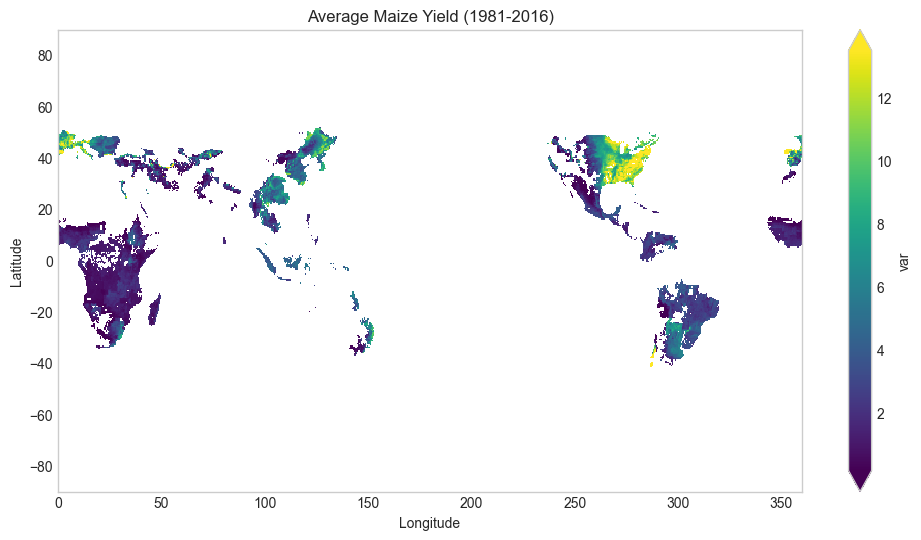

In [2]:
# Cell 2: Data Summary and Map (Corrected)

# Get the specific data variable we care about (which we now know is named 'var')
maize_yield = ds['var']

# --- Create a Summary Table ---
# xarray.DataArray doesn't have a built-in .describe() method like pandas.
# We compute the statistics individually and then create a pandas Series for a nice display.
print("--- Summary Statistics for Maize Yield (tonnes/hectare) ---")

# .load() brings the data from dask into memory, which is good before computing multiple stats.
maize_yield.load()

summary_data = {
    'mean': maize_yield.mean().item(),
    'std': maize_yield.std().item(),
    'min': maize_yield.min().item(),
    '25%': maize_yield.quantile(0.25).item(),
    '50% (median)': maize_yield.median().item(),
    '75%': maize_yield.quantile(0.75).item(),
    'max': maize_yield.max().item(),
}
summary_series = pd.Series(summary_data)
print(summary_series)

# --- Create the Map ---
# Create a map of the average yield over the entire period to see the main growing regions.
# We calculate the mean along the 'time' dimension.
# We also replace zeros with 'NaN' (Not a Number) so they don't skew the color map. This makes oceans and non-growing areas blank.
mean_yield_map = maize_yield.mean(dim='time').where(maize_yield.mean(dim='time') > 0)

# Plotting the map
plt.figure(figsize=(12, 6))
mean_yield_map.plot(cmap='viridis', robust=True) # robust=True handles outliers in the color scale
plt.title('Average Maize Yield (1981-2016)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## 2. Time Series Analysis

How has maize yield changed over time? We'll start by looking at the global trend.

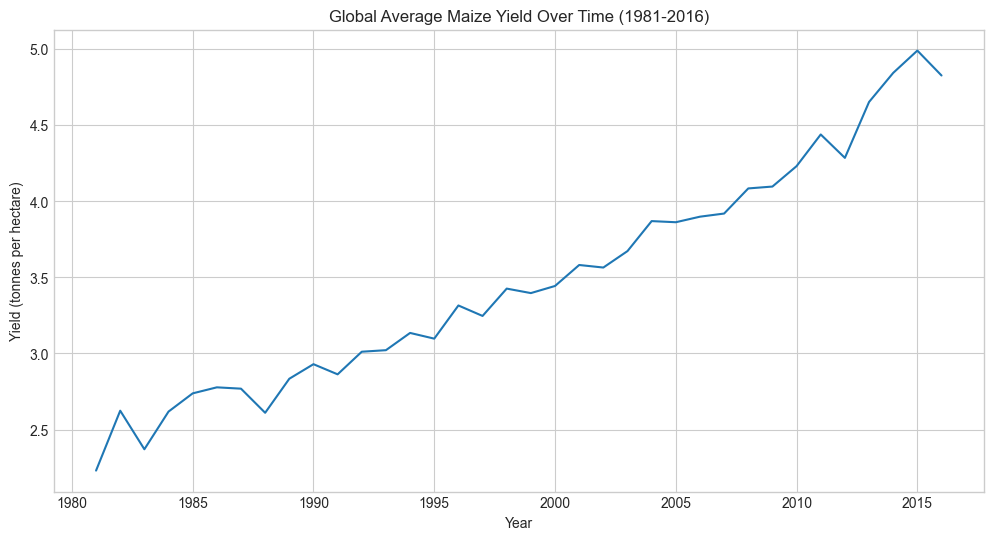

In [3]:
# Cell 3: Global Yield Trend Over Time

# To get the global trend, we calculate the mean yield across space (lat, lon) for each year.
# We can't just do a simple mean because grid cells are different sizes (smaller at the poles).
# We must create weights based on the cosine of the latitude to account for this.
weights = np.cos(np.deg2rad(maize_yield.lat))
weights.name = "weights"

# Apply the weights to our data
weighted_yield = maize_yield.weighted(weights)

# Calculate the weighted mean across the spatial dimensions ("lon", "lat") for each time step
global_mean_yield = weighted_yield.mean(dim=("lon", "lat"))

# Plot the time series
plt.figure(figsize=(12, 6))
global_mean_yield.plot()
plt.title('Global Average Maize Yield Over Time (1981-2016)')
plt.ylabel('Yield (tonnes per hectare)')
plt.xlabel('Year')
plt.grid(True) # Add grid lines for easier reading
plt.show()

## 3. Regional Comparison

The global average can hide important regional differences. Let's compare the yield trends in two contrasting maize-growing regions: the high-yield, temperate system of the United States versus the lower-yield, tropical system of Nigeria.

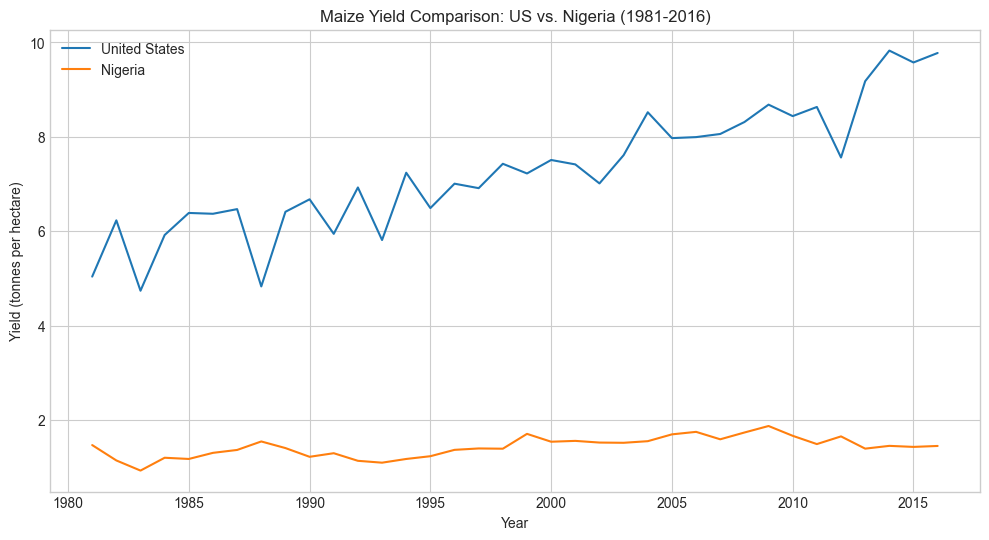

In [4]:
# Cell 4: Regional Time Series Comparison

# Define the latitude and longitude bounds for our regions of interest
# These are approximate bounding boxes for each country's main agricultural areas.
us_bounds = {'lat': slice(25, 50), 'lon': slice(235, 295)} # Longitude in 0-360
nigeria_bounds = {'lat': slice(4, 14), 'lon': slice(2, 15)}

# Select the data for each region using the .sel() method
us_yield = maize_yield.sel(**us_bounds)
nigeria_yield = maize_yield.sel(**nigeria_bounds)

# Calculate the weighted average yield for each region over time
us_mean_yield = us_yield.weighted(np.cos(np.deg2rad(us_yield.lat))).mean(dim=("lon", "lat"))
nigeria_mean_yield = nigeria_yield.weighted(np.cos(np.deg2rad(nigeria_yield.lat))).mean(dim=("lon", "lat"))

# Plot both time series on the same graph for comparison
plt.figure(figsize=(12, 6))
us_mean_yield.plot(label='United States')
nigeria_mean_yield.plot(label='Nigeria')
plt.title('Maize Yield Comparison: US vs. Nigeria (1981-2016)')
plt.ylabel('Yield (tonnes per hectare)')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

## 4. Initial EDA Summary & Next Steps

**Summary of Findings:**

*   **Data Structure & Quality:** The dataset is a 3D cube (lat, lon, time) covering 1981-2016. It loaded correctly, and the spatial and temporal dimensions are as expected.
*   **Global Trend:** The global average yield shows a strong upward trend, doubling from ~2.5 to ~5.0 t/ha. This "technology trend" is the dominant signal in the raw data. The year-to-year fluctuations around this trend are what we will investigate as potential climate signals.
*   **Regional Differences:** The comparison between the US and Nigeria highlights the critical need for stratification.
    *   The **US** shows high absolute yields and a steep growth trend but also exhibits extreme year-to-year variability, suggesting high sensitivity to shocks.
    *   **Nigeria** shows low absolute yields and a much flatter growth trend, representing a completely different agricultural system.
*   **Conclusion:** The EDA confirms the dataset is suitable for our project. The clear regional differences validate our plan to stratify the analysis rather than relying on global averages.

**Next Steps: Moving to the Main Analysis**

This EDA is now complete. Our next phase of work will be to link this yield data to climate data to build our first vulnerability curves. This will likely involve:
1.  **Sourcing Climate Data:** Finding and downloading a gridded climate dataset (e.g., temperature and precipitation) that matches our data's spatial and temporal resolution.
2.  **Calculating Yield Anomalies:** We will need to "de-trend" the yield data to remove the long-term technology signal and isolate the year-to-year variability.
3.  **Creating our first scatter plot:** Plotting yield anomalies against a climate variable (like growing-season temperature) to look for the dose-response relationship that will become our first vulnerability curve.